# Film Data from Box Office Mojo and IMDb

### Goal: explore available film data in the context of gender inequality in Hollywood

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import json
import pymysql

import collect
import analyze

In [ ]:
help(collect)

In [ ]:
movies_df = analyze.get_gender_data_from_db(glim=[10000000,100000000])
movies_df.head()

## Looking at gender breakdown by year

The `field` argument can be changed to any of the roles explored (cast,writers,directors,etc.)

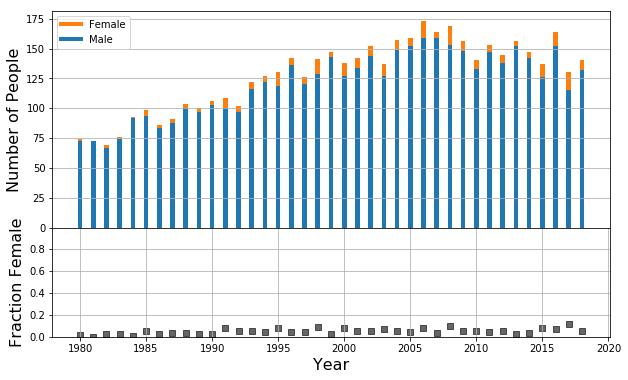

In [23]:
analyze.plot_yearly_data(1980,2018,field='directors')

## With a corner plot, can explore potential correlations between any of the fields
The data here are the gender counts per movie.

In [ ]:
analyze.corner_plot(1980,2018)

### Looking closer at producers vs. cast plot

In [ ]:
analyze.corr_plot('writers','writers')

TO DO:

Let's say we want to bring *fraction female* for `cast` closer to 0.5. 

**Are there features that track well with *fraction female* for `cast`?**

Need to assess the gross earnings cutoff before going much further.

Eventually, set up a classification problem, defining categories e.g., fraction > 0.4 and fraction < 0.4.

In [2]:
df = analyze.engineer_features_lol()

Skipping Oliver & Company
Skipping Justin Bieber: Never Say Never
Skipping Michael Jackson's This Is It
Skipping Hero
Skipping Deep Sea 3D (IMAX)
Skipping Wonder Park
Skipping The Beverly Hillbillies
Skipping Paddington 2
Skipping Song of the South (Re-issue) (1980)
Skipping Bounce
Skipping Under the Sea 3D
Skipping Smokin' Aces
Skipping White Fang
Skipping Magnificent Desolation (IMAX)
Skipping Monster Trucks
Skipping Bend It Like Beckham
Skipping Unfriended
Skipping Rumble in the Bronx
Skipping Earth (2009)
Skipping The Bear
Skipping The Debt
Skipping Dragon Ball Super: Broly
Skipping Toy Story / Toy Story 2 (3D)
Skipping Open Water
Skipping Underworld: Blood Wars
Skipping Daybreakers
Skipping The Gods Must Be Crazy
Skipping Spice World
Skipping One Direction: This is Us
Skipping Oculus
Skipping Brooklyn's Finest
Skipping Resident Evil: The Final Chapter
Skipping The Woman in Black 2: Angel of Death
Skipping The Descent
Skipping Born to Be Wild (IMAX)
Skipping Memento
Skipping Katy P

In [87]:
df = df.dropna()
df['gross'] = df['gross']/np.max(df['gross'])
X = df[['gross','directors_ff','producers_ff','writers_ff']]
#X = df[['directors_ff','producers_ff','writers_ff']]

df.loc[df.cast_ff < 0.4, 'cast_ff'] = 0
df.loc[df.cast_ff >= 0.4, 'cast_ff'] = 1

y = df['cast_ff']

X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X,y, test_size=0.2)
#pd.get_dummies(df['studio'])

#garr = np.array([])
#for row in df['genres']:
#    try:
#        garr = np.append(garr,json.loads(row))
#    except TypeError:
#        continue
#genres_keys = np.unique(garr)

In [88]:
lrm = sklearn.linear_model.LinearRegression()
rdgCV = sklearn.linear_model.RidgeCV(alphas=[0.01,0.1,1,10,100,1000], cv=5)
lrm.fit(X_train,y_train)
rdgCV.fit(X_train,y_train)

RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), cv=5,
        fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [89]:
lrm.score(X_train,y_train)
print(rdgCV.alpha_)

1.0


In [90]:
lrm.score(X_valid,y_valid)

0.05019124812815001

In [108]:
rdg = sklearn.linear_model.Ridge(alpha=1)
rdg.fit(X_train, y_train)
print(rdg.score(X_train, y_train))
print(rdg.score(X_valid, y_valid))

0.060092411045454375
0.050325528874832104


In [109]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
rfr = RandomForestRegressor(n_jobs=-1, n_estimators=100)
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=100,class_weight={0:0.001,1:1})

In [110]:
rfr.fit(X_train,y_train)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.001, 1: 1},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [102]:
print(rfr.score(X_train,y_train))
print(rfr.score(X_valid,y_valid))
print(rfc.score(X_train,y_train))
print(rfc.score(X_valid,y_valid))
print(rfc.score(X_valid,y_valid))

0.8406264618780908
-0.1977993495252368
0.9997336174746937
0.8817891373801917
0.8817891373801917


In [103]:
print(rfc.feature_importances_)
#print(rfc.decision_path(X=X_valid))

[0.78191391 0.01196357 0.16661049 0.03951202]


In [104]:
from sklearn import metrics
gt = y_valid
pr = rfc.predict(X_valid)
metrics.accuracy_score(gt,pr)
metrics.balanced_accuracy_score(gt,pr)

0.5158920539730135

In [105]:
fmissed = np.size(np.where(gt-pr == 1.0)[0])
mmisscl = np.size(np.where(gt-pr == -1.0)[0])
ftot = np.size(np.where(gt == 1.0)[0])
mtot = np.size(np.where(gt == 0)[0])

In [106]:
print(fmissed,ftot)

63 69


In [107]:
print(mmisscl,mtot)

48 870
